# 🎛️ Fine-tune a SetFit model using the ArgillaTrainer

In this example, we will show how to use the `ArgillaTrainer` to fine-tune a SetFit model on a `FeedbackDataset` made of categorical questions like `LabelQuestion` and `MultiLabelQuestion`.

We will start from this [tutorial for setfit](./labelling-feedback-setfit.html), using the same dataset and adapting it to the new trainer class. Some background can be found in this [ArgillaTrainer guide](../../../practical_guides/fine_tune.md) if needed.

Let's get started!

<div class="alert alert-info">

Note

This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or on a Jupyter notebook tool of your choice.

</div>


## Setup

For this tutorial, you will need to have an Argilla server running. If you don't have one already, check out our [Quickstart](../../../getting_started/quickstart.md) or [Installation](../../../getting_started/quickstart_installation.ipynb) pages. Once you do, complete the following steps:

1. Install the Argilla client and the required third-party libraries using `pip`:

In [3]:
!pip install argilla setfit

2. Let's make the necessary imports:

In [1]:
import argilla as rg
from datasets import load_dataset
from argilla.feedback import ArgillaTrainer, FeedbackDataset, TrainingTaskMapping

3. If you are running Argilla using the Docker quickstart image or Hugging Face Spaces, you need to `init` the Argilla client with the `URL` and `API_KEY`:

In [ ]:
# Replace api_url with the url to your local host if using Docker or your HF Spaces url
# Replace api_key if you configured a custom API key
rg.init(
    api_url=r"https://<YOUR-HF-SPACE>.hf.space",
    api_key="admin.apikey"
)

If you're running a private Hugging Face Space, you will also need to set the [HF_TOKEN](https://huggingface.co/settings/tokens) as follows:

In [ ]:
# # Set the HF_TOKEN environment variable
# import os
# os.environ['HF_TOKEN'] = "your-hf-token"

# # Replace api_url with the url to your HF Spaces URL
# # Replace api_key if you configured a custom API key
# rg.init(
#     api_url=r"https://<YOUR-HF-SPACE>.hf.space", 
#     api_key="admin.apikey",
#     extra_headers={"Authorization": f"Bearer {os.environ['HF_TOKEN']}"},
# )

### Enable Telemetry

We gain valuable insights from how you interact with our tutorials. To improve ourselves in offering you the most suitable content, using the following lines of code will help us understand that this tutorial is serving you effectively. Though this is entirely anonymous, you can choose to skip this step if you prefer. For more info, please check out the [Telemetry](../../reference/telemetry.md) page.

In [ ]:
try:
    from argilla.utils.telemetry import tutorial_running
    tutorial_running()
except ImportError:
    print("Telemetry is introduced in Argilla 1.20.0 and not found in the current installation. Skipping telemetry.")

## Configure the dataset

In this example, we will load a popular open-source dataset that has customer requests in the banking domain.

In [3]:
data = load_dataset("PolyAI/banking77", split="test")

We will configure our dataset with two different questions so that we can work with two text classification tasks at the same time. In this case, we will load the original labels of this dataset to make a multi-label classification of the topics mentioned in the request and we will also set up a question to classify the sentiment of the request as either "positive", "neutral" or "negative".

In [4]:
dataset = rg.FeedbackDataset(
    guidelines="Add some guidelines for the annotation team here.",
    fields=[
        rg.TextField(name="text", title="banking topics")
    ],
    questions=[
        rg.MultiLabelQuestion(
            name="topics",
            title="Select the topic(s) of the request",
            labels=data.info.features['label'].names, #these are the original labels present in the dataset
            visible_labels=10
        ),
        rg.LabelQuestion(
            name="sentiment",
            title="What is the sentiment of the message?",
            labels=["positive", "neutral", "negative"]
        )
    ]
)

### Define the task mapping

We will train two different models, one for the `LabelQuestion` with the sentiment, and a second one with `MultiLabelQuestion` for the original topics of the dataset. For this, we will use the `TrainingTaskMapping.for_text_classification`.

In [5]:
task_mapping_topics = TrainingTaskMapping.for_text_classification(
    text=dataset.field_by_name("text"),
    label=dataset.question_by_name("topics")
)
task_mapping_sentiment = TrainingTaskMapping.for_text_classification(
    text=dataset.field_by_name("text"),
    label=dataset.question_by_name("sentiment")
)

### Creating the records for our dataset

At this point, our dataset contains the structure but no records to train our model. The examples have the topics already labeled, but that's not the case for the sentiment. In this case, we will use a [transformer model](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest) pretrained to get the sentiment.

Let's create the records.

In [ ]:
from transformers import pipeline

sentiment_classifier = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment-latest")

In [52]:
import random

random.seed(1234)

record_indices = random.choices(range(len(data)), k=8)


def get_sentiment(text: str) -> str:
    return sentiment_classifier(text)[0]["label"]


def topic_int2str(label_int: int) -> str:
    return data.features["label"].int2str(label_int)


records = [
    rg.FeedbackRecord(
        fields={"text": record['text']},
        responses=[
            {
                "values": {
                    # Get the sentiment from a pretrained transformer model
                    "sentiment": {"value": get_sentiment(record["text"])},
                    # Add the topics as a list
                    "topics": {"value": [topic_int2str(record["label"])]}
                }
            }
        ]
    )
    for record in data.select(record_indices)
]

Let's review the previous block of code. Please note that this `FeedbackDataset` only serves for demo purposes. We will select just 8 examples (in `record_indices` we store the indices of the records that we will grab from the original dataset) for faster training, and obtain the sentiment from our `sentiment_classifier`. We have a model good enough for our purposes available at the [hugging face hub](https://huggingface.co/models), but if that would not be the case, we could use a "good enough" one to get suggestions and label it properly to train our model, have a look at this [tutorial](./labelling-feedback-setfit.ipynb#Train-the-models) for more information.

Regarding the topics, the original dataset is already labeled, so we only need to insert the corresponding name. `topic_int2str` does the mapping for us.

Let's add the records to our dataset:

In [55]:
dataset.add_records(records=records)

In [68]:
dataset.format_as("datasets").to_pandas()[-3:][["text", "topics", "sentiment"]]

,text,topics,sentiment
5,My refund is missing,"[{'user_id': None, 'value': ['Refund_not_showi...","[{'user_id': None, 'value': 'negative', 'statu..."
6,How long does it take to process transfers fro...,"[{'user_id': None, 'value': ['transfer_timing'...","[{'user_id': None, 'value': 'neutral', 'status..."
7,Will you handle EUR?,"[{'user_id': None, 'value': ['fiat_currency_su...","[{'user_id': None, 'value': 'neutral', 'status..."


In [ ]:
ds = dataset.push_to_argilla("setfit_training_tutorial", workspace="admin")

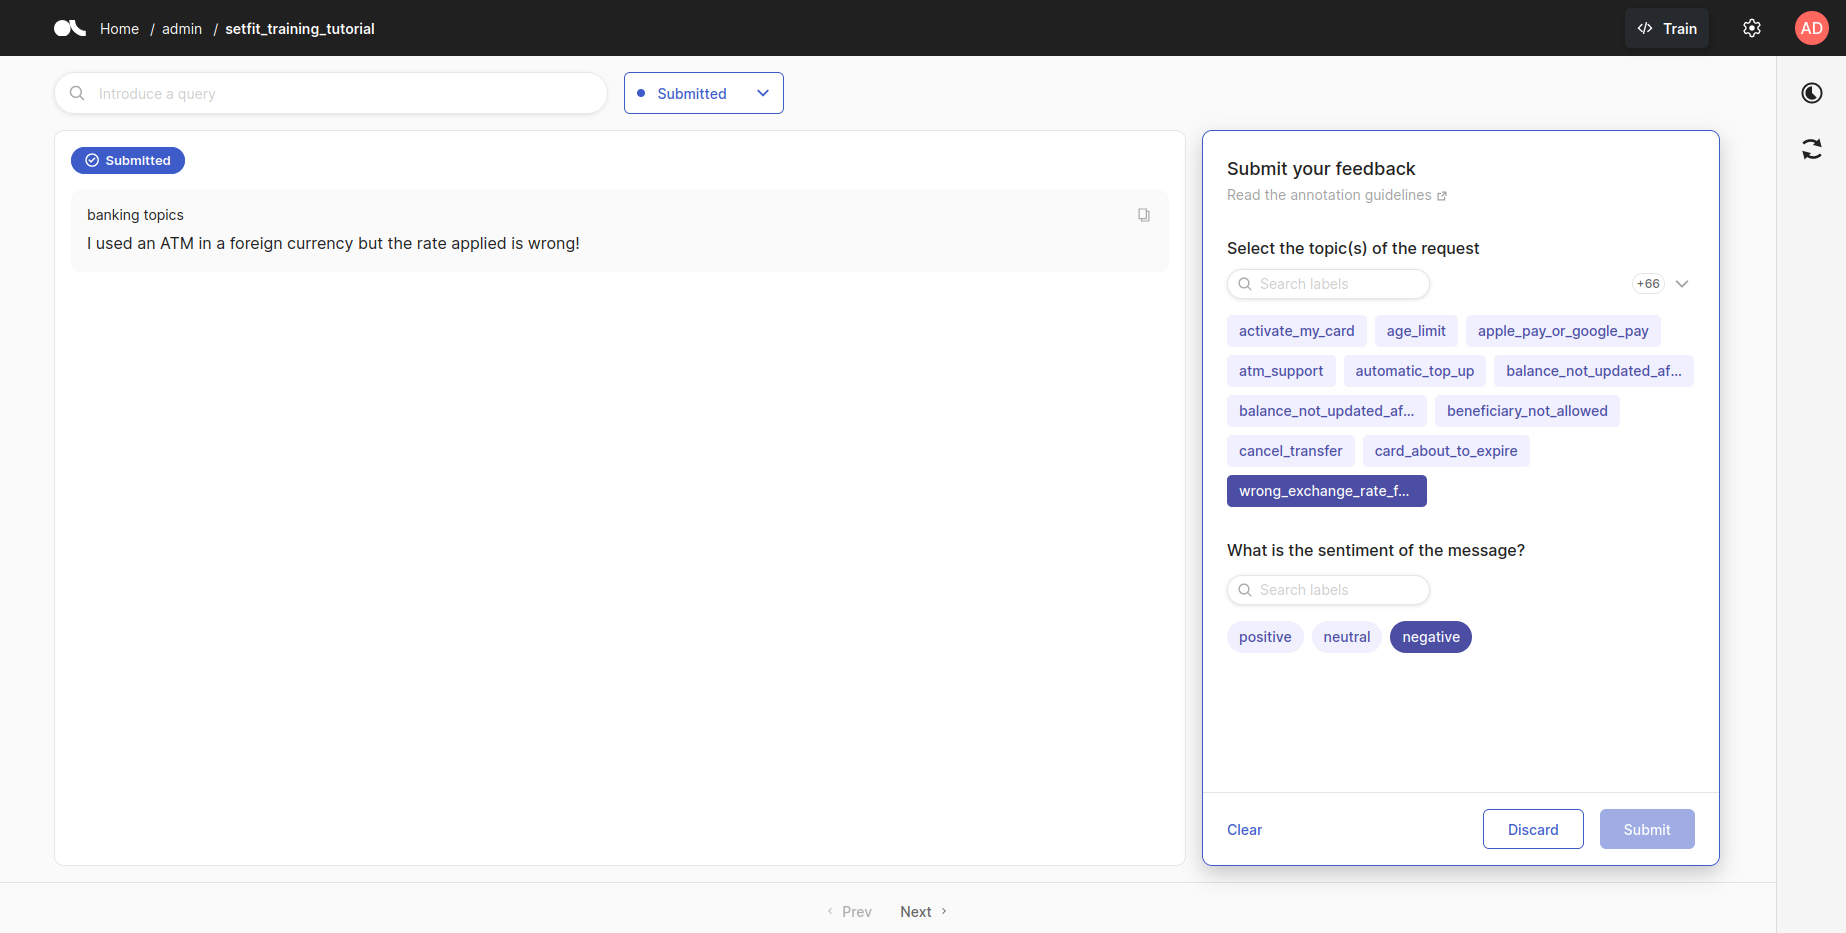

## Train the models

Now we will train two different models for each task, just by using the appropriate *task_mapping*, and save them to their corresponding folders:

In [ ]:
trainer_sentiment = ArgillaTrainer(
    dataset=dataset,
    task=task_mapping_sentiment,
    framework="setfit",
)
trainer_sentiment.update_config(
    num_train_epochs=1,
)
trainer_sentiment.train(output_dir="sentiment_model")

In [ ]:
trainer_topics = ArgillaTrainer(
    dataset=dataset,
    task=task_mapping_topics,
    framework="setfit",
)
trainer_topics.update_config(num_train_epochs=1)
trainer_topics.train(output_dir="topics_model")

## Make predictions

Following the previous tutorial, let's obtain the predictions with our freshly trained models. 
First, we adapt the function from the previous tutorial to use our `ArgillaTrainer.predict` method.

In [384]:
def get_predictions(texts, model):
    return model.predict(texts)

Apply the predictions to our subset, and look at the resulting dataset.

In [ ]:
subset = data.select(record_indices)
subset = subset.map(
    lambda batch: {
        "topics": get_predictions(batch["text"], trainer_topics),
        "sentiment": get_predictions(batch["text"], trainer_sentiment),
    },
    batched=True,
)

In [387]:
subset.to_pandas().set_index("text").head()

,label,topics,sentiment
text,,,
I used an ATM in a foreign currency but the rate applied is wrong!,76,"{'activate_my_card': 0.11339724732947638, 'age...","{'negative': 0.30721275251644486, 'neutral': 0..."
I don't understand why it says I have to verify the top-up.,71,"{'activate_my_card': 0.11338630825105621, 'age...","{'negative': 0.19467522210149565, 'neutral': 0..."
I submitted a transaction to the incorrect account.,8,"{'activate_my_card': 0.2284524559678986, 'age_...","{'negative': 0.20868444521020138, 'neutral': 0..."
What currencies is an exchange rate calculated in?,32,"{'activate_my_card': 0.10659121602923811, 'age...","{'negative': 0.433266446947898, 'neutral': 0.1..."
Do you know where my card will be accepted?,10,"{'activate_my_card': 0.10908837526993907, 'age...","{'negative': 0.30172024225859906, 'neutral': 0..."


## Conclusion

In this tutorial, we have covered how to train a SetFit model using the new `ArgillaTrainer` with a `FeedbackDataset`. Building on the Add zero-shot suggestions using SetFit tutorial we have learned how to train models on our datasets using the new Argilla APIs, without leaving Argilla.

To learn more about SetFit, check out these links:

- [SetFit repo on GitHub](https://github.com/huggingface/setfit)
- [SetFit documentation](https://huggingface.co/docs/setfit/index)